# Chapter2 PyMCについてもう少し
## 例題：ベイズ的A/Bテスト
- webサイトのCV率の評価
    - 真のCV率：$p_A$ <-この真の値はわからない。これを知りたい
- 訪問者数：$N$
- コンバージョン数：$n$
- 問題：観測された$N$と$n$から、真の$p_A$を推定したい

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt

### 単純な場合
- $p_A$の事前分布：[0,1]の一様分布とする（何の情報もない）


シミュレーションで観測したCV数:74
シミュレーションで観測したCV頻度:0.04933333333333333
 [-----------------100%-----------------] 20000 of 20000 complete in 3.0 sec

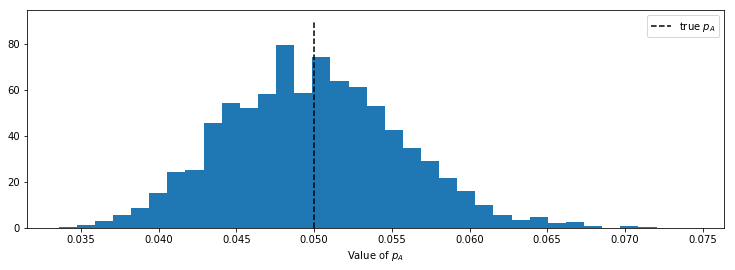

In [2]:
import pymc as pm

# 事前分布
p = pm.Uniform("p", lower=0, upper=1)


# *** 人工データをシミュレーションする

# 真のp_A(本当は未知の値)
p_true = 0.05
# 訪問者数の設定
N = 1500

# 事象はベルヌーイ分布からサンプルされると仮定する
## シミュレーションで観測データを生成する
## 実際は、これはCVしたかしないかの実際の観測データ列になる（列数は当然、訪問者数のN）
occurrences = pm.rbernoulli(p_true, N)
print("シミュレーションで観測したCV数:{}".format(occurrences.sum()))
print("シミュレーションで観測したCV頻度:{}".format(occurrences.mean()))

## p_Aの推論をする
### 観測データ. データはベルヌーイ分布に従うとする 
### 観測データなので、observed=Trueで観測済みとする
obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)
### 推論ステップ
mcmc = pm.MCMC([p, obs])
mcmc.sample(20000, 1000)

## 事後分布のプロット
figsize(12.5, 4)

plt.vlines(p_true, 0, 90, linestyles="--", label="true $p_A$")
plt.hist(mcmc.trace("p")[:], bins=35, histtype="stepfilled", normed=True)
plt.xlabel("Value of $p_A$")
plt.legend()

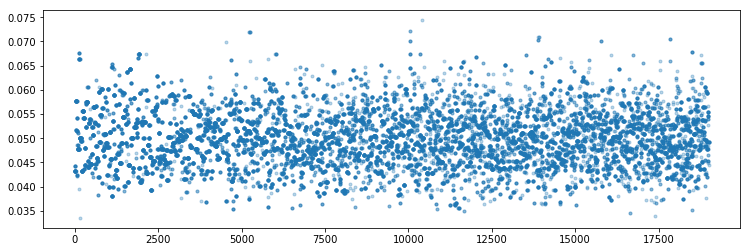

In [3]:
plt.plot(mcmc.trace("p")[:], '.', alpha=0.3)

### AとBを一緒に
- 本当に知りたいのは、サイトAとBでどっちが効果があるのかということ（A/Bテストなので）
- サイトBのCV率を$p_B$とする
- $p_A$と$p_B$の差を評価するので、$p_A - p_B$を推論したい

In [4]:
figsize(12, 4)

# 真のCV率（本当は未知）
true_p_A = 0.05
true_p_B = 0.04

# 訪問者数の設定（サンプルサイズ） → サンプルサイズが異なるのは現実ではよくあること
N_A = 1500
N_B = 750

# 観測データを作る
observation_A = pm.rbernoulli(true_p_A, N_A)
observation_B = pm.rbernoulli(true_p_B, N_B)
print(observation_A.mean())
print(observation_B.mean())

0.0566666666667
0.044


In [5]:
# PnMCモデルの設定

# p_A, p_Bの事前分布
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)

# AとBの差を表す変数（これも予測対象で、p_Aとp_Bがわかれば決定的）
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# 観測データ
obs_A = pm.Bernoulli("obs_A", p_A, value=observation_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observation_B, observed=True)

mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(25000, 5000)

 [-----------------100%-----------------] 25000 of 25000 complete in 5.8 sec

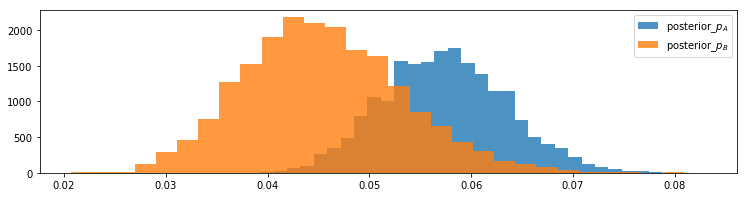

In [6]:
p_A_sample = mcmc.trace("p_A")[:]
p_B_sample = mcmc.trace("p_B")[:]
delta_sample = mcmc.trace("delta")[:]

figsize(12.5, 3)

plt.hist(p_A_sample, bins=30, alpha=0.8, label="posterior_$p_A$")
plt.hist(p_B_sample, bins=30, alpha=0.8, label="posterior_$p_B$")

plt.legend()


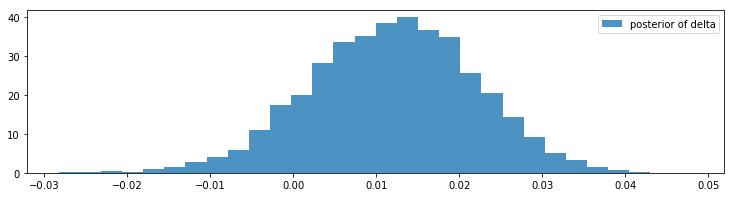

In [7]:
plt.hist(delta_sample, bins=30, alpha=0.8, label="posterior of delta", normed=True)
plt.legend()

In [8]:
print("サイトAがサイトBよりもCV率が悪い確率 : %.3f" % (delta_sample<0.).mean())
print("サイトAがサイトBよりもCV率が良い確率 : %.3f" % (delta_sample>0.).mean())

サイトAがサイトBよりもCV率が悪い確率 : 0.117
サイトAがサイトBよりもCV率が良い確率 : 0.883


## 例題：カンニングをした学生の割合
- 試験を受験する学生数：$N$
- 学生がカンニングをする頻度$p$を求めたい

### プライバシーアルゴリズム
```
カンニングしたかしてないかを面接で聞く。
この時、学生は誰にも見えないようにコインを投げ（確率1/2で）、表が出たら正直に応える。
裏が出たら、確率1/2でランダムに回答をする（もう一回コインを投げる）。
```

In [9]:
import pymc as pm

N = 100
# カンニングをする確率の事前分布を一様分布とする
p = pm.Uniform("freq_cheating", 0, 1)

# 正しい答えの分布はベルヌーイ分布
# 確率pでカンニングした学生がいる
true_answer = pm.Bernoulli("truth", p, size=N)


In [10]:
# プライバシーアルゴリズム
## コインを投げて正直に答えるかランダムに答えるかが決まる
first_coin_flips = pm.Bernoulli("first_flips", 0.5, size=N)
print(first_coin_flips.value)

[ True  True False False  True False False  True  True  True  True False
  True False  True  True False False  True False False False  True False
 False  True False  True False  True  True  True  True False False  True
  True False False  True False False  True  True False False False False
 False False False  True False False False  True False  True  True  True
  True False False False  True  True False False False  True  True  True
  True  True False  True False False False False  True False  True False
 False  True  True  True False False  True False  True False  True  True
 False  True False False]


In [11]:
## 2回めのコイン投げは全員やるわけではないが、生成過程は同じでモデル化
second_coin_flips = pm.Bernoulli("second_flips", 0.5, size=N)

In [12]:
## Yesという回答（カンニングしました）がサンプルされる過程
@pm.deterministic
def observed_proportion(t_a=true_answer, fc=first_coin_flips, sc=second_coin_flips):
    observed = fc * t_a + (1 - fc) * sc # (1回めのコインでYesが得られる数)＋(2回めのコインでYesが得られる数)
    return observed.sum() / float(N) # Yesが得られる頻度（割合）


In [13]:
# 観測データ、Yesの回答を得た数がX観測されたとする
X = 35

observations = pm.Binomial("obs", N, observed_proportion, observed=True, value=X)

In [14]:
# 予測ステップ
model = pm.Model([p, true_answer, first_coin_flips, second_coin_flips, 
                 observed_proportion, observations])
mcmc = pm.MCMC(model)
mcmc.sample(40000, 15000)

 [-----------------100%-----------------] 40000 of 40000 complete in 12.1 sec

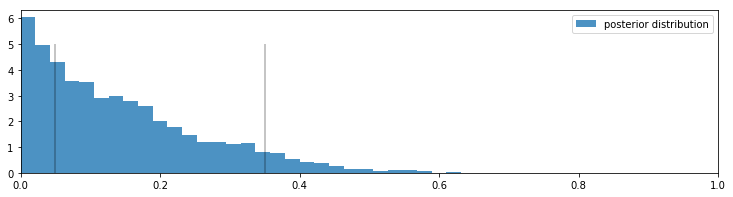

In [15]:
figsize(12.5, 3)

p_trace = mcmc.trace("freq_cheating")[:]
plt.hist(p_trace, normed=True, alpha=0.8, bins=30, label="posterior distribution")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend()

## 例題：スペースシャトル「チャレンジャー号」の悲劇
- チャレンジャー号(24回めのスペースシャトル)の事故原因はOリングの破損が原因
- Oリングが外気温などの要因にたいして敏感すぎるという設計上の不具合であった
- Oリングに関するデータは23回の成功したフライトで計測されたものがある

### 問題の確認
- 以下の気温と故障有無の散布図から、気温が下がると故障が増えると見える
- 気温tの時の故障発生確率を導くことが問題

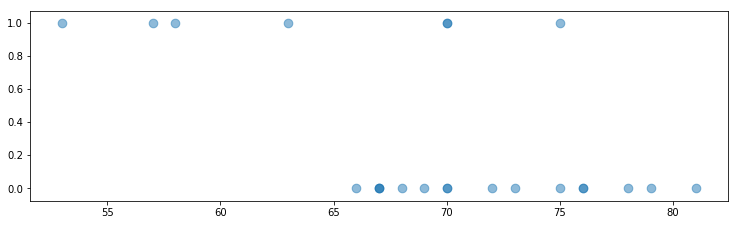

In [16]:
# データはgithubから落とせる

figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)

challenger_data = np.genfromtxt('data/challenger_data.csv', 
                                skip_header=1, usecols=[1,2], 
                                missing_values="NA", delimiter=",")
# NaNの削除
challenger_data = challenger_data[~np.isnan(challenger_data[:,1])]

# 気温データのプロット
plt.scatter(x=challenger_data[:,0], y=challenger_data[:,1], s=75, alpha=0.5)

# x軸：気温（華氏）、y軸：故障有無

### 故障確率の推定
- 気温yを変数、故障発生確率を$p(t)$とする
    - $p(t)$は気温が低いほど1に近く、上昇するにつれて0に近づいていく
    - 確率表現なので、値域は0~1の間になるので、$p(t)$のモデルをロジスティック関数とする
$$p(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

- 上記のパラメータ$\alpha$と$\beta$の事前分布については、特に何の事前情報も無いので正規分布を使う
    - 正規分布の分散（精度）を大きくして、一様分布状にして推定する

In [49]:
import pymc as pm

temperature = challenger_data[:,0]
D = challenger_data[:,1]

# p(t)のパラメータの事前分布
## value=0で初期値を0に固定。値が大きな値になると観測のモデルにするベルヌーイ分布の計算上不都合
## なので、初期値を0に固定する
beta = pm.Normal("beta", 0.0, 0.001, value=0) # 第3引数は精度（分散の逆数）
alpha = pm.Normal("alpha", 0.0, 0.001, value=0) # 第3引数は精度（分散の逆数）

@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    """
    p(t)のdeterministic変数の定義
    正規分布
    """
    return 1.0/(1. + np.exp(beta*t + alpha))

In [50]:
# 観測値
observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)

model = pm.Model([observed, beta, alpha])

map_ = pm.MAP(model) # MAP推定で初期値を計算
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000, 2)

 [-----------------100%-----------------] 120000 of 120000 complete in 12.7 sec

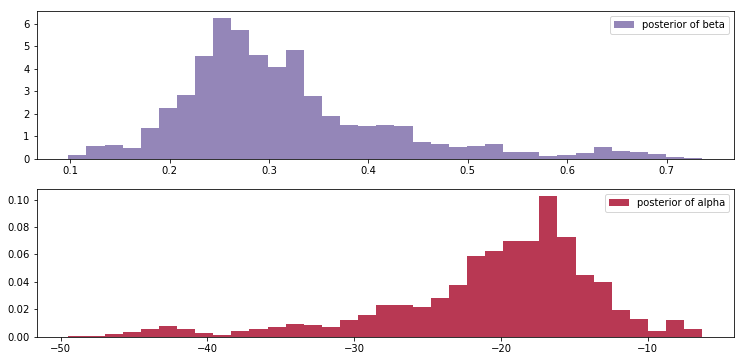

In [54]:
figsize(12.5, 6)

alpha_samples = mcmc.trace('alpha')[:, None]
beta_samples = mcmc.trace('beta')[:, None]

plt.subplot(211)
plt.hist(beta_samples, bins=35, alpha=0.8, color="#7a68a6", normed=True, 
        label="posterior of beta")
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, bins=35, alpha=0.8, color="#a60628", normed=True, 
        label="posterior of alpha")
plt.legend()


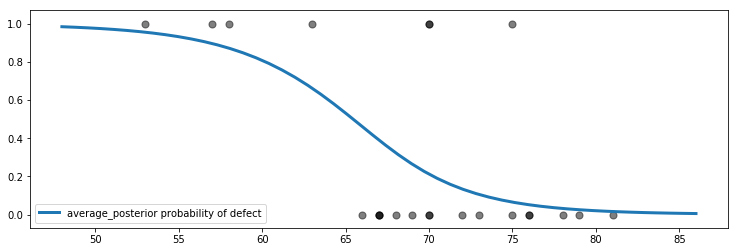

In [56]:
# 外気温についての故障の期待確率
figsize(12.5, 4)

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0) # 平均事後確率

plt.plot(t, mean_prob_t, lw=3, label='average_posterior probability of defect')
plt.scatter(temperature, D, color='k', s=50, alpha=0.5)
plt.legend()


In [57]:
from scipy.mstats import mquantiles

# 信用区間
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7, color='#7a68a6')
plt.plot(t, mean_prob_t, lw=3, label='average_posterior probability')


ModuleNotFoundError: No module named 'scipy.mstats'